In [103]:
import os
import pandas as pd 
import numpy as np 
import ast
import heapq
from typing import List, Tuple
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
load_dotenv()
import Levenshtein
from Levenshtein import ratio
from urllib.parse import unquote
import openai
openai.api_key = os.getenv("openai")


In [114]:
input_data=pd.read_csv('data/final_checkpoint_clean.csv')
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   countydescription        206 non-null    object 
 1   schoolname               206 non-null    object 
 2   principal/directoremail  206 non-null    object 
 3   website                  206 non-null    object 
 4   board_of_directors_link  206 non-null    object 
 5   link_domain_match        206 non-null    bool   
 6   director_first_last      206 non-null    object 
 7   cleaner_names            206 non-null    object 
 8   zipcode                  206 non-null    int64  
 9   political_affilation     206 non-null    object 
 10  postal_code              206 non-null    int64  
 11  latitude                 206 non-null    float64
 12  longitude                206 non-null    float64
 13  count_dem                206 non-null    int64  
 14  count_rep                2

In [7]:
#read in state vote registration data 
state_voter=pd.read_csv('data/ncvoter_Statewide.txt',sep="\t", header=0,encoding='ISO-8859-1')
state_voter.info()

C:\Users\chris\AppData\Local\Temp\ipykernel_8324\250504983.py:2: DtypeWarning: Columns (23,34,35,36,37,38,39,41,42,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  state_voter=pd.read_csv('data/ncvoter_Statewide.txt',sep="\t", header=0,encoding='ISO-8859-1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8248674 entries, 0 to 8248673
Data columns (total 67 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   county_id                 int64  
 1   county_desc               object 
 2   voter_reg_num             int64  
 3   ncid                      object 
 4   last_name                 object 
 5   first_name                object 
 6   middle_name               object 
 7   name_suffix_lbl           object 
 8   status_cd                 object 
 9   voter_status_desc         object 
 10  reason_cd                 object 
 11  voter_status_reason_desc  object 
 12  res_street_address        object 
 13  res_city_desc             object 
 14  state_cd                  object 
 15  zip_code                  float64
 16  mail_addr1                object 
 17  mail_addr2                object 
 18  mail_addr3                object 
 19  mail_addr4                object 
 20  mail_city               

In [5]:
# from each name find the most similar name in the voter registration data and county location and return list of voter affilation
## data quality check
# sanity check make sure input_data and state_voter have the same county names as state_voter
input_county_list=input_data['countydescription'].unique()
input_county_list=list(map(lambda x: x.upper(), input_county_list))
state_county_list=state_voter['county_desc'].unique()
def find_difference(list1, list2):
    return list(set(list1) - set(list2))
difference = find_difference(input_county_list, state_county_list)
print(f'here are the difference between county list {difference}')  # Output: [1, 2]

NameError: name 'input_data' is not defined

In [61]:
## define helper functions

# google search function 
def get_google_search_results_boards(district: str):
    # set the school name to search for
    # create a Google search query URL
    query_url = f"https://www.google.com/search?q={district}+county+meet+the+board+of+education+members"
    # make a request to the query URL and get the HTML content
    response = requests.get(query_url)
    html_content = response.text
    # parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')
    # find all the search result links on the page
    search_result_links = soup.find_all('a')
    # extract the URLs of the first search result link from each search engine
    result_urls = []
    for link in search_result_links:
        href = link.get('href')
        if href.startswith('/url?q='):
            result_url = href.split('/url?q=')[1].split('&')[0]
            #result_url = unquote(result_url)  #test this out 
            result_urls.append(result_url)
        if len(result_urls) == 1:
            break
    # print the resulting URLs
    return(result_urls)


# double check this function because state_vote is not defined
def find_political_affiliation(list_names: List[str], lat: float, lon: float) -> List[str]:
    party_list = []
    for name in list_names:
        name = name.upper()
        scores = []
        for i, voter_name in enumerate(state_voter['full_name']):
            similarity = lexical_similarity(name, voter_name)
            if len(scores) < 50:
                # If we don't have 50 scores yet, just add it to the heap.
                heapq.heappush(scores, (similarity, i))
            else:
                # If we already have 50 scores, add the new one and remove the smallest.
                heapq.heappushpop(scores, (similarity, i))
        # Get the indices of the top 50 most similar names.
        top_indices = [i for _, i in scores]
        # Calculate distances for these 50 records.
        distances = calculate_distance(lat, lon, state_voter.loc[top_indices, 'latitude'], state_voter.loc[top_indices, 'longitude'])
        # Pair up similarities and distances, then sort by similarity first and distance second.
        sorted_records = sorted(zip(scores, distances), key=lambda x: (-x[0][0], x[1]))
        # Get the political affiliation of the top record.
        top_record_index = sorted_records[0][0][1]
        top_party = state_voter.loc[top_record_index, 'party_cd']
        party_list.append(top_party)
    return party_list
# get content 

def extract_main_content(url):
    try:
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
        response = requests.get(url,headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the URL: {e}")
        return None

    soup = BeautifulSoup(response.content, "html.parser")

    # Remove unwanted elements
    for tag in ['header', 'footer', 'nav']:
        elements_to_remove = soup.find_all(tag)
        for elem in elements_to_remove:
            elem.decompose()

    # Extract text from the remaining elements
    text_content = ' '.join(soup.stripped_strings)
    # remove extra spaces and line breaks
    text_content = re.sub(r"\s+", " ", text_content).strip()
    # add spaces between words that are capitalized
    text_content = re.sub(r'(?<!^)(?=[A-Z])', ' ', text_content)
    # remove punctuation
    words = text_content.split()
    # remove single word characters because of middle initials
    filtered_words = [word for word in words if len(word) > 1]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

## clean open ai reponses from the chunk of text
def openai_cleaner(input_string:str):
    input_string = input_string.replace('\'','')
    input_string = input_string.replace('[','')
    input_string = input_string.replace(']','')
    input_string = input_string.replace('\"','')
    input_string = input_string.replace("NA", "")
    input_string = input_string.replace("\n", "")
    input_string = input_string.replace("\\\\n\\\\n", "")
    input_string=input_string.replace("(", "").replace(")", "")
    input_string=input_string.replace("\\\\n", "")
    input_string=input_string.replace("Answer:", "")
    input_string=input_string.replace("answer:", "")
    input_string = re.sub(r'(\n[\s]*)+', ' ', input_string)
    # Remove patterns such as \n\nAnswer:, \n\n(, ), and (list)
    patterns = ['Answer:', '\(\w+\)', '\(list\)']
    for pattern in patterns:
        input_string = re.sub(r'\n\n{}[\s]*'.format(pattern), ' ', input_string)
    # Remove leading and trailing whitespaces
    input_string = input_string.strip()
    words_to_remove = ['Director', 'Assistant', 'Parent Seat','Parent', 'Seat', 'Community', 'Board', 'Treasurer','Alumni','-','Business Analyst']
    
    for word in words_to_remove:
        input_string = input_string.replace(word, "")
    
    return input_string 

# similar names 
def lexical_similarity(name, name_column):
    name_column = name_column.apply(lambda x: Levenshtein.ratio(name, x))
    return name_column

In [6]:
# use distinct on input data to find county names for google search api

#create the dataframe from charter school data
board_ed = pd.DataFrame({'countydescription': input_data['countydescription'].unique()})
board_ed.shape
#only 63 counties have charter schools in NC

In [16]:
# get text content per website from each link 
board_ed['board_of_directors_link']=board_ed['countydescription'].apply(get_google_search_results_boards)

In [25]:
board_ed['board_of_directors_link']=board_ed['board_of_directors_link'].apply(lambda x: x[0]) #get first link from google search - might be obselete if you unquote the url in function

In [33]:
board_ed['text_content']=board_ed['board_of_directors_link'].apply(extract_main_content)

An error occurred while fetching the URL: 400 Client Error: Bad Request for url: https://www.chathamcountync.gov/government/departments-programs-a-h/elections/elected-officials/board-of-education-districts%3Flocale%3Den
An error occurred while fetching the URL: 404 Client Error: Not Found for url: https://www.davidson.k12.nc.us/apps/pages/index.jsp%3FuREC_ID%3D797270%26type%3Dd%26pREC_ID%3D1188026
An error occurred while fetching the URL: 404 Client Error: Not Found for url: https://www.ecps.us/apps/pages/index.jsp%3FuREC_ID%3D1632444%26type%3Dd
An error occurred while fetching the URL: 404 Client Error: Not Found for url: https://www.pamlicoschools.org/apps/pages/index.jsp%3FuREC_ID%3D786866%26type%3Dd%26pREC_ID%3D1178555
An error occurred while fetching the URL: 404 Client Error: Not Found for url: https://www.rcschools.net/apps/pages/index.jsp%3FuREC_ID%3D523314%26type%3Dd%26pREC_ID%3D1039530
An error occurred while fetching the URL: 404 Client Error: Not Found for url: https://www.

In [35]:
board_ed['text_content'].head()

0    Board of Education Board Members Skip to Main ...
1    Meet the Board Members Alamance- Burlington Sc...
2    Board of Education Avery County Schools Skip t...
3    Board of Education Beaufort County School Dist...
4    Bladen, Pender and Columbus counties swear in ...
Name: text_content, dtype: object

In [52]:
def extract_names_from_text(text):
    response = openai.Completion.create(
        engine='text-davinci-003',
        prompt=f"context: {text} \n\n question: Who are the board members with first and last names?, give it to me as a python list If none are available give me an empty list.",
        temperature=0.86,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return [choice['text'].strip() for choice in response.choices]

def chunked_extract_names_from_text(text):
    max_token_limit = 4000
    chunks = [text[i:i + max_token_limit] for i in range(0, len(text), max_token_limit)]
    extracted_names = []
    
    for chunk in chunks:
        extracted_names.extend(extract_names_from_text(chunk))
    
    return extracted_names
# Load the pandas DataFrame with the text column

# Extract names from the text column
#board_ed['extract_name'] = board_ed['text_content'].apply(chunked_extract_names_from_text)

board_ed['extract_name'] = board_ed['text_content'].apply(lambda x: chunked_extract_names_from_text(x) if x else '')

In [58]:
board_ed['extract_name'] = board_ed['extract_name'].astype(str)

In [62]:
# use openai to find board of directors names from each website text content 
board_ed['extract_name_clean']=board_ed['extract_name'].apply(openai_cleaner)

In [60]:
board_ed['extract_name_clean'] ## more to clean up tbh

0     Bettina Umstead, Emily Chávez, Natalie Beyer, ...
1      Members:\nSandy EllingtonGraves, Ryan Bowden,...
2     John Greene, Kathey Aldridge, Pat Edwards, Ran...
3     \nChristina Gwozdz, Richard Geier, Angela Midd...
4     Harfel Davis, Dennis Edwards, Steve Kwiatkowsk...
                            ...                        
58    answer: Linda Byrd, Joyce Long, Jennifer Sims,...
59    answer: Carlos Riddick, Lois Clark, Fred Norma...
60    answer: Gary L. Childers, John Fenwick, John A...
61    Wade Leatham, Craig Foucht, H. Len Henderson, ...
62    Debora Powell, Velma Barnes, Christine L. Fitc...
Name: extract_name_clean, Length: 63, dtype: object

In [93]:
board_ed.to_csv('board_ed.csv',index=False)

In [62]:
board_ed=pd.read_csv('board_ed.csv') 

In [86]:
board_ed['extract_name_clean'] = board_ed['extract_name_clean'].fillna('')
board_ed['extract_name_clean_list']=board_ed['extract_name_clean'].apply(lambda x: x.split(','))

In [6]:
board_ed['countydescription']

0         Durham
1       Alamance
2          Avery
3       Beaufort
4         Bladen
         ...    
58        Warren
59    Washington
60       Watauga
61         Wayne
62        Wilson
Name: countydescription, Length: 63, dtype: object

In [4]:
board_ed.head()

,countydescription,board_of_directors_link,text_content,extract_name,extract_name_clean,extract_name_clean_list
0,Durham,https://www.dpsnc.net/Page/3629,Board of Education Board Members Skip to Main ...,"['Answer: [""Bettina Umstead"", ""Emily Chávez"", ...","Bettina Umstead, Emily Chavez, Natalie Beyer, ...","['Bettina Umstead', ' Emily Chavez', ' Natalie..."
1,Alamance,https://www.abss.k12.nc.us/page/board-of-educa...,Meet the Board Members Alamance- Burlington Sc...,"['Board Members:\nSandy Ellington-Graves, Ryan...","Sandy EllingtonGraves, Ryan Bowden, Dan Ingle,...","['Sandy EllingtonGraves', ' Ryan Bowden', ' Da..."
2,Avery,https://www.averyschools.net/page/board-of-edu...,Board of Education Avery County Schools Skip t...,"['Answer: [""John Greene"", ""Kathey Aldridge"", ""...","John Greene, Kathey Aldridge, Pat Edwards, Ran...","['John Greene', ' Kathey Aldridge', ' Pat Edwa..."
3,Beaufort,https://www.beaufortschools.net/about-us/board...,Board of Education Beaufort County School Dist...,"[""Answer:\n['Christina Gwozdz', 'Richard Geier...","Christina Gwozdz, Richard Geier, Angela Middle...","['Christina Gwozdz', ' Richard Geier', ' Angel..."
4,Bladen,https://www.wect.com/2022/12/16/bladen-pender-...,"Bladen, Pender and Columbus counties swear in ...","[""Answer: ['Harfel Davis', 'Dennis Edwards', '...","Harfel Davis, Dennis Edwards, Steve Kwiatkowsk...","['Harfel Davis', ' Dennis Edwards', ' Steve Kw..."


In [8]:
# DE for state voter - Drop zipcode, combine first and last name
state_voter=state_voter.loc[(state_voter['voter_status_desc'] == 'ACTIVE') & (state_voter['zip_code'].notna())]
state_voter=state_voter.dropna(subset=['first_name','last_name'], how='all')
state_voter[['first_name','last_name']]=state_voter[['first_name','last_name']].astype(str)
state_voter['full_name'] = state_voter[['first_name','last_name']].apply(lambda x: ' '.join(x), axis=1)

In [9]:
state_voter['full_name']

0                  RUTH AABEL
2          TIMOTHY AARMSTRONG
3             CHRISTINA AARON
4               CLAUDIA AARON
5                 JAMES AARON
                  ...        
8248667          JAMES ZITNEY
8248669       MICHELLE ZITNEY
8248670       VICTORIA ZITNEY
8248671           DAWN ZULICK
8248672      PAMELA ZULLINGER
Name: full_name, Length: 6276955, dtype: object

In [110]:
# def find_political_affil(name_list:List, county:str)-> List: 
#     results=[]
#     state_voter_county=state_voter.loc[state_voter['county_desc']==county.upper()]
#     for name in name_list:
#         find_max=lexical_similarity(name.upper(),state_voter_county['full_name'])
#         value = state_voter_county.loc[find_max.idxmax(), 'party_cd']
#         results.append(value)
#     return results

# def lexical_similarity(name, name_column):
#     name_column = name_column.apply(lambda x: Levenshtein.ratio(name, x))
#     return name_column


def find_political_affil(name_list: List, county: str) -> List[str]:
    results = []
    # Filter the DataFrame once at the beginning and convert names to upper case.
    state_voter_county = state_voter.loc[state_voter['county_desc'] == county.upper()]
    #state_voter_county['full_name'] = state_voter_county['full_name'].str.upper()
    for name in name_list:
        # Vectorize the lexical similarity calculation.
        if name.strip() == '':
            continue
        similarities = state_voter_county['full_name'].apply(ratio, args=(name.upper(),))
        value = state_voter_county.loc[similarities.idxmax(), 'party_cd']
        results.append(value)
        
    return results


In [107]:
sample_list=['Lucy Edwards','Clinton Williams', 'Eric Smith', '']
sample_county = 'Northampton'
find_political_affil(sample_list, sample_county)

Lucy Edwards
Clinton Williams
Eric Smith


['DEM', 'DEM', 'DEM']

In [111]:

#find lexical similarity between charter school board of directors and state voter names and geogrphical location by county
# assume that the board of directors are registered voters in the county they serve
#board_ed['extract_name_clean_list'].apply(lambda x: print(x,board_ed['countydescription']))
board_ed['political_afil']=board_ed.apply(lambda row: find_political_affil(ast.literal_eval(row['extract_name_clean_list']), row['countydescription']), axis=1)

In [112]:
board_ed.head()

,countydescription,board_of_directors_link,text_content,extract_name,extract_name_clean,extract_name_clean_list,political_afil
0,Durham,https://www.dpsnc.net/Page/3629,Board of Education Board Members Skip to Main ...,"['Answer: [""Bettina Umstead"", ""Emily Chávez"", ...","Bettina Umstead, Emily Chavez, Natalie Beyer, ...","['Bettina Umstead', ' Emily Chavez', ' Natalie...","[DEM, UNA, DEM, DEM, DEM, DEM, DEM]"
1,Alamance,https://www.abss.k12.nc.us/page/board-of-educa...,Meet the Board Members Alamance- Burlington Sc...,"['Board Members:\nSandy Ellington-Graves, Ryan...","Sandy EllingtonGraves, Ryan Bowden, Dan Ingle,...","['Sandy EllingtonGraves', ' Ryan Bowden', ' Da...","[REP, REP, REP, DEM, DEM, DEM, DEM, REP]"
2,Avery,https://www.averyschools.net/page/board-of-edu...,Board of Education Avery County Schools Skip t...,"['Answer: [""John Greene"", ""Kathey Aldridge"", ""...","John Greene, Kathey Aldridge, Pat Edwards, Ran...","['John Greene', ' Kathey Aldridge', ' Pat Edwa...","[REP, REP, REP, REP]"
3,Beaufort,https://www.beaufortschools.net/about-us/board...,Board of Education Beaufort County School Dist...,"[""Answer:\n['Christina Gwozdz', 'Richard Geier...","Christina Gwozdz, Richard Geier, Angela Middle...","['Christina Gwozdz', ' Richard Geier', ' Angel...","[DEM, REP, DEM, REP, REP, DEM, REP, UNA, REP, ..."
4,Bladen,https://www.wect.com/2022/12/16/bladen-pender-...,"Bladen, Pender and Columbus counties swear in ...","[""Answer: ['Harfel Davis', 'Dennis Edwards', '...","Harfel Davis, Dennis Edwards, Steve Kwiatkowsk...","['Harfel Davis', ' Dennis Edwards', ' Steve Kw...","[DEM, REP, REP, REP, DEM, DEM, DEM, UNA, UNA, ..."


In [180]:
#export the dataset for review
board_ed.to_csv('board_ed.csv',index=False)

In [115]:
input_data['countydescription'].unique()

array(['Durham', 'Alamance', 'Avery', 'Beaufort', 'Bladen', 'Brunswick',
       'Buncombe', 'Burke', 'Cabarrus', 'Caldwell', 'Carteret', 'Chatham',
       'Cleveland', 'Columbus', 'Cumberland', 'Currituck', 'Davidson',
       'Edgecombe', 'Forsyth', 'Franklin', 'Gaston', 'Granville',
       'Guilford', 'Halifax', 'Harnett', 'Haywood', 'Henderson',
       'Iredell', 'Jackson', 'Johnston', 'Lee', 'Lenoir', 'Lincoln',
       'Martin', 'Mecklenburg', 'Montgomery', 'Moore', 'Nash',
       'New Hanover', 'Northampton', 'Onslow', 'Orange', 'Pamlico',
       'Pasquotank', 'Person', 'Pitt', 'Randolph', 'Robeson',
       'Rockingham', 'Rowan', 'Rutherford', 'Stanly', 'Surry', 'Swain',
       'Transylvania', 'Union', 'Vance', 'Wake', 'Warren', 'Washington',
       'Watauga', 'Wayne', 'Wilson'], dtype=object)

In [129]:
board_ed[['countydescription','political_afil']]

,countydescription,political_afil
0,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]"
1,Alamance,"[REP, REP, REP, DEM, DEM, DEM, DEM, REP]"
2,Avery,"[REP, REP, REP, REP]"
3,Beaufort,"[DEM, REP, DEM, REP, REP, DEM, REP, UNA, REP, ..."
4,Bladen,"[DEM, REP, REP, REP, DEM, DEM, DEM, UNA, UNA, ..."
...,...,...
58,Warren,"[UNA, DEM, DEM, DEM, DEM]"
59,Washington,"[DEM, DEM, DEM, DEM, DEM]"
60,Watauga,"[UNA, UNA, DEM, DEM, REP, UNA, REP, DEM, DEM, ..."
61,Wayne,"[REP, REP, DEM, DEM, UNA, REP]"


In [131]:
merge_charter_district=board_ed[['countydescription','political_afil','extract_name_clean_list']].merge(input_data, on='countydescription')

In [133]:
merge_charter_district.head()

,countydescription,political_afil,extract_name_clean_list,schoolname,principal/directoremail,website,board_of_directors_link,link_domain_match,director_first_last,cleaner_names,zipcode,political_affilation,postal_code,latitude,longitude,count_dem,count_rep,count_una
0,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",North Carolina Cyber Academy,mhill@myncca.com,myncca.com,https://www.myncca.com/our-school-board,True,"[('Jill', 'Hammergren'), ('Audrey', 'Martin'),...","['Julie Marks', 'Jill Hammergren', 'Debora Wil...",27713,"['DEM', 'DEM', 'REP', 'DEM', 'REP', 'DEM', 'DEM']",27713,35.9112,-78.9178,5,2,0
1,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",NC Virtual Academy,kgomersall@ncvacademy.org,ncvacademy.org,https://ncva.k12.com/about-our-school/board-of...,False,"[('Sara', 'W'), ('C.', 'Struhs'), ('Sara', 'St...","['Steven Peters', 'Sara Struhs', 'Mark Fleming...",27713,"['UNA', 'REP', 'DEM', 'DEM', 'UNA', 'REP']",27713,35.9112,-78.9178,2,2,2
2,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Maureen Joy Charter School,Dcannon@joycharter.org,joycharter.org,https://www.joycharter.org/board,True,"[('Elan', 'Hope'), ('Helen', 'Bryant'), ('Regi...","['Elan Hope', 'Helen Bryant', 'Reginald J. Joh...",27703,"['UNA', 'DEM', 'DEM', 'REP', 'DEM', 'UNA', 'DE...",27703,35.9781,-78.8439,6,1,2
3,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Durham Charter School,aquigley@durhamcharter.org,durhamcharter.org,https://www.durhamcharter.org/board-of-directors/,True,"[('Matt', 'Les'), ('Preston', 'Michael'), ('Ca...","['Gerald Mc Nair', 'Elizabeth Gnatek Morey Ch...",27701,"['REP', 'REP', 'DEM', 'REP', 'UNA', 'UNA', 'DE...",27701,35.9967,-78.8966,2,4,4
4,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Community School of Digital & Visual Art,OAdeniyi@communitydva.org,communitydva.org,https://www.communitydva.org/,True,[],"['Brian Crawford', 'Joe Battle', 'Michael Palm...",27705,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM']",27705,36.0218,-78.9478,5,0,1


In [134]:
def count_dem(lst):
    return lst.count('DEM')
def count_rep(lst):
    return lst.count('REP')
def count_una(lst):
    return lst.count('UNA')

In [135]:
merge_charter_district['district_count_dem']=merge_charter_district['political_afil'].apply(count_dem)
merge_charter_district['district_count_rep']=merge_charter_district['political_afil'].apply(count_rep)
merge_charter_district['district_count_una']=merge_charter_district['political_afil'].apply(count_una)

In [136]:
merge_charter_district

,countydescription,political_afil,extract_name_clean_list,schoolname,principal/directoremail,website,board_of_directors_link,link_domain_match,director_first_last,cleaner_names,...,political_affilation,postal_code,latitude,longitude,count_dem,count_rep,count_una,district_count_dem,district_count_rep,district_count_una
0,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",North Carolina Cyber Academy,mhill@myncca.com,myncca.com,https://www.myncca.com/our-school-board,True,"[('Jill', 'Hammergren'), ('Audrey', 'Martin'),...","['Julie Marks', 'Jill Hammergren', 'Debora Wil...",...,"['DEM', 'DEM', 'REP', 'DEM', 'REP', 'DEM', 'DEM']",27713,35.9112,-78.9178,5,2,0,6,0,1
1,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",NC Virtual Academy,kgomersall@ncvacademy.org,ncvacademy.org,https://ncva.k12.com/about-our-school/board-of...,False,"[('Sara', 'W'), ('C.', 'Struhs'), ('Sara', 'St...","['Steven Peters', 'Sara Struhs', 'Mark Fleming...",...,"['UNA', 'REP', 'DEM', 'DEM', 'UNA', 'REP']",27713,35.9112,-78.9178,2,2,2,6,0,1
2,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Maureen Joy Charter School,Dcannon@joycharter.org,joycharter.org,https://www.joycharter.org/board,True,"[('Elan', 'Hope'), ('Helen', 'Bryant'), ('Regi...","['Elan Hope', 'Helen Bryant', 'Reginald J. Joh...",...,"['UNA', 'DEM', 'DEM', 'REP', 'DEM', 'UNA', 'DE...",27703,35.9781,-78.8439,6,1,2,6,0,1
3,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Durham Charter School,aquigley@durhamcharter.org,durhamcharter.org,https://www.durhamcharter.org/board-of-directors/,True,"[('Matt', 'Les'), ('Preston', 'Michael'), ('Ca...","['Gerald Mc Nair', 'Elizabeth Gnatek Morey Ch...",...,"['REP', 'REP', 'DEM', 'REP', 'UNA', 'UNA', 'DE...",27701,35.9967,-78.8966,2,4,4,6,0,1
4,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Community School of Digital & Visual Art,OAdeniyi@communitydva.org,communitydva.org,https://www.communitydva.org/,True,[],"['Brian Crawford', 'Joe Battle', 'Michael Palm...",...,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM']",27705,36.0218,-78.9478,5,0,1,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Watauga,"[UNA, UNA, DEM, DEM, REP, UNA, REP, DEM, DEM, ...","['Gary L. Childers', ' John Fenwick', ' John A...",Two Rivers Community School,natalie@trcsboone.org,trcsboone.org,https://www.trgators.org/o/two-rivers-school-d...,False,"[('Stele', 'James'), ('Doug', 'Morell'), ('Rya...","['Melissa Thomas', 'Carole Greene', 'Twila Win...",...,"['UNA', 'DEM', 'DEM', 'UNA', 'UNA']",28607,36.2142,-81.6660,2,0,3,6,6,5
202,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Dillard Academy,cbattle@dillardacademy.org,dillardacademy.org,http://www.dillardacademy.org/board-of-directo...,True,"[('Janet', 'Ward'), ('Thomas', 'Smith'), ('Mar...","['Janet Ward', 'Christina Robles', 'Mary James...",...,"['DEM', 'DEM', 'REP', 'UNA', 'REP', 'REP', 'DEM']",27530,35.3683,-78.0929,3,3,1,2,3,1
203,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Wayne Preparatory Academy,jtwitty@wpanc.org,wpanc.org,https://wpanc.net/our-board/,False,"[('Amanda', 'Wells'), ('Scott', 'Mack'), ('Cha...","['Charles Gaylor', 'Scott Mackey', 'Amanda Wel...",...,"['DEM', 'REP', 'UNA', 'LIB']",27530,35.3683,-78.0929,1,1,1,2,3,1
204,Wilson,"[DEM, DEM, DEM, UNA, DEM, UNA, REP]","['Debora Powell', ' Velma Barnes', ' Christine...",Sallie B Howard School,"jwoodard@sallieb.net, sandeep@sallieb.net",sallieb.net,https://salliebhowardschool.com/meet-our-staff...,False,"[('JoAnne', 'Woodard'), ('JoAnne', 'Woodard')]",['JoAnne Woodard'],...,['REP'],27893,35.7270,-77.9227,0,1,0,4,1,2


In [137]:
# out put the final csv for board of education
merge_charter_district.to_csv('merge_charter_district.csv',index=False)

In [138]:
# merge the county board of education affilation back to final_checkpoint_clean.csv
merge_charter_district

,countydescription,political_afil,extract_name_clean_list,schoolname,principal/directoremail,website,board_of_directors_link,link_domain_match,director_first_last,cleaner_names,...,political_affilation,postal_code,latitude,longitude,count_dem,count_rep,count_una,district_count_dem,district_count_rep,district_count_una
0,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",North Carolina Cyber Academy,mhill@myncca.com,myncca.com,https://www.myncca.com/our-school-board,True,"[('Jill', 'Hammergren'), ('Audrey', 'Martin'),...","['Julie Marks', 'Jill Hammergren', 'Debora Wil...",...,"['DEM', 'DEM', 'REP', 'DEM', 'REP', 'DEM', 'DEM']",27713,35.9112,-78.9178,5,2,0,6,0,1
1,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",NC Virtual Academy,kgomersall@ncvacademy.org,ncvacademy.org,https://ncva.k12.com/about-our-school/board-of...,False,"[('Sara', 'W'), ('C.', 'Struhs'), ('Sara', 'St...","['Steven Peters', 'Sara Struhs', 'Mark Fleming...",...,"['UNA', 'REP', 'DEM', 'DEM', 'UNA', 'REP']",27713,35.9112,-78.9178,2,2,2,6,0,1
2,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Maureen Joy Charter School,Dcannon@joycharter.org,joycharter.org,https://www.joycharter.org/board,True,"[('Elan', 'Hope'), ('Helen', 'Bryant'), ('Regi...","['Elan Hope', 'Helen Bryant', 'Reginald J. Joh...",...,"['UNA', 'DEM', 'DEM', 'REP', 'DEM', 'UNA', 'DE...",27703,35.9781,-78.8439,6,1,2,6,0,1
3,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Durham Charter School,aquigley@durhamcharter.org,durhamcharter.org,https://www.durhamcharter.org/board-of-directors/,True,"[('Matt', 'Les'), ('Preston', 'Michael'), ('Ca...","['Gerald Mc Nair', 'Elizabeth Gnatek Morey Ch...",...,"['REP', 'REP', 'DEM', 'REP', 'UNA', 'UNA', 'DE...",27701,35.9967,-78.8966,2,4,4,6,0,1
4,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Community School of Digital & Visual Art,OAdeniyi@communitydva.org,communitydva.org,https://www.communitydva.org/,True,[],"['Brian Crawford', 'Joe Battle', 'Michael Palm...",...,"['DEM', 'UNA', 'DEM', 'DEM', 'DEM', 'DEM']",27705,36.0218,-78.9478,5,0,1,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Watauga,"[UNA, UNA, DEM, DEM, REP, UNA, REP, DEM, DEM, ...","['Gary L. Childers', ' John Fenwick', ' John A...",Two Rivers Community School,natalie@trcsboone.org,trcsboone.org,https://www.trgators.org/o/two-rivers-school-d...,False,"[('Stele', 'James'), ('Doug', 'Morell'), ('Rya...","['Melissa Thomas', 'Carole Greene', 'Twila Win...",...,"['UNA', 'DEM', 'DEM', 'UNA', 'UNA']",28607,36.2142,-81.6660,2,0,3,6,6,5
202,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Dillard Academy,cbattle@dillardacademy.org,dillardacademy.org,http://www.dillardacademy.org/board-of-directo...,True,"[('Janet', 'Ward'), ('Thomas', 'Smith'), ('Mar...","['Janet Ward', 'Christina Robles', 'Mary James...",...,"['DEM', 'DEM', 'REP', 'UNA', 'REP', 'REP', 'DEM']",27530,35.3683,-78.0929,3,3,1,2,3,1
203,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Wayne Preparatory Academy,jtwitty@wpanc.org,wpanc.org,https://wpanc.net/our-board/,False,"[('Amanda', 'Wells'), ('Scott', 'Mack'), ('Cha...","['Charles Gaylor', 'Scott Mackey', 'Amanda Wel...",...,"['DEM', 'REP', 'UNA', 'LIB']",27530,35.3683,-78.0929,1,1,1,2,3,1
204,Wilson,"[DEM, DEM, DEM, UNA, DEM, UNA, REP]","['Debora Powell', ' Velma Barnes', ' Christine...",Sallie B Howard School,"jwoodard@sallieb.net, sandeep@sallieb.net",sallieb.net,https://salliebhowardschool.com/meet-our-staff...,False,"[('JoAnne', 'Woodard'), ('JoAnne', 'Woodard')]",['JoAnne Woodard'],...,['REP'],27893,35.7270,-77.9227,0,1,0,4,1,2


In [141]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


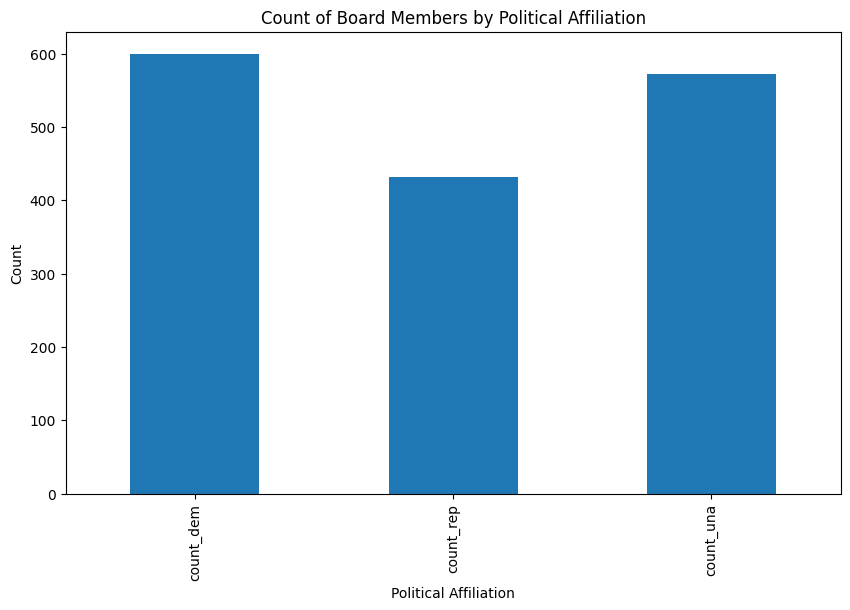

In [142]:
plt.figure(figsize=(10, 6))
affiliation_columns = ['count_dem', 'count_rep', 'count_una']
merge_charter_district[affiliation_columns].sum().plot(kind='bar')
plt.title('Count of Board Members by Political Affiliation')
plt.xlabel('Political Affiliation')
plt.ylabel('Count')
plt.show()

In [146]:
merge_charter_district.columns

Index(['countydescription', 'political_afil', 'extract_name_clean_list',
       'schoolname', 'principal/directoremail', 'website',
       'board_of_directors_link', 'link_domain_match', 'director_first_last',
       'cleaner_names', 'zipcode', 'political_affilation', 'postal_code',
       'latitude', 'longitude', 'count_dem', 'count_rep', 'count_una',
       'district_count_dem', 'district_count_rep', 'district_count_una',
       'Percentage'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

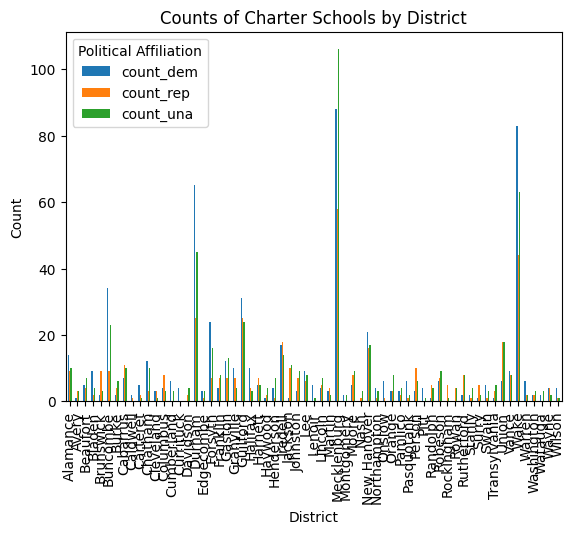

In [147]:
plt.figure(figsize=(10, 6))
merge_charter_district.groupby('countydescription')[['count_dem', 'count_rep', 'count_una']].sum().plot(kind='bar')
plt.title('Counts of Charter Schools by District')
plt.xlabel('District')
plt.ylabel('Count')
plt.legend(title='Political Affiliation')
plt.show()

<Figure size 1000x600 with 0 Axes>

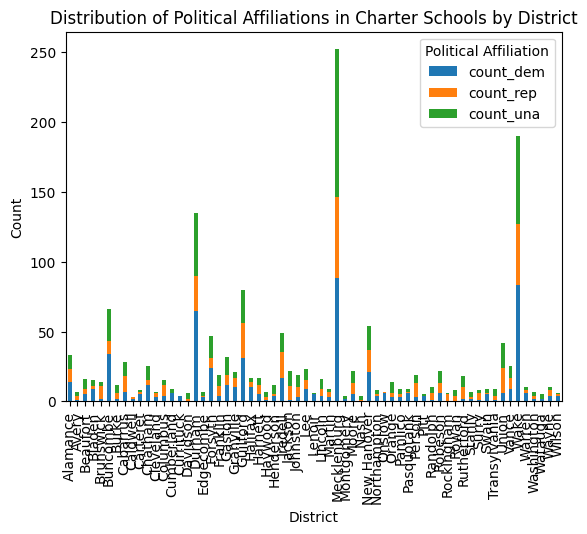

In [149]:
plt.figure(figsize=(10, 6))
merge_charter_district.groupby('countydescription')[['count_dem', 'count_rep', 'count_una']].sum().plot(kind='bar', stacked=True)
plt.title('Distribution of Political Affiliations in Charter Schools by District')
plt.xlabel('District')
plt.ylabel('Count')
plt.legend(title='Political Affiliation')
plt.show()

In [176]:
district_counts = merge_charter_district.groupby('countydescription')['count_dem'].sum()
threshold_count = 5

In [177]:
heavy_dem_districts = district_counts[district_counts >= threshold_count].index
other_districts = district_counts[district_counts < threshold_count].index

print("Charter Heavy Democratic Districts:")
print(heavy_dem_districts)

print("Other Districts:")
print(other_districts)

Charter Heavy Democratic Districts:
Index(['Alamance', 'Beaufort', 'Bladen', 'Buncombe', 'Cabarrus', 'Carteret',
       'Chatham', 'Cumberland', 'Durham', 'Forsyth', 'Gaston', 'Granville',
       'Guilford', 'Halifax', 'Harnett', 'Iredell', 'Lee', 'Lenoir',
       'Mecklenburg', 'Moore', 'New Hanover', 'Onslow', 'Pasquotank',
       'Robeson', 'Swain', 'Union', 'Vance', 'Wake', 'Warren'],
      dtype='object', name='countydescription')
Other Districts:
Index(['Avery', 'Brunswick', 'Burke', 'Caldwell', 'Cleveland', 'Columbus',
       'Currituck', 'Davidson', 'Edgecombe', 'Franklin', 'Haywood',
       'Henderson', 'Jackson', 'Johnston', 'Lincoln', 'Martin', 'Montgomery',
       'Nash', 'Northampton', 'Orange', 'Pamlico', 'Person', 'Pitt',
       'Randolph', 'Rockingham', 'Rowan', 'Rutherford', 'Stanly', 'Surry',
       'Transylvania', 'Washington', 'Watauga', 'Wayne', 'Wilson'],
      dtype='object', name='countydescription')


In [166]:
board_ed['district_count_dem']=board_ed['political_afil'].apply(count_dem)
board_ed['district_count_rep']=board_ed['political_afil'].apply(count_rep)
board_ed['district_count_una']=board_ed['political_afil'].apply(count_una)

In [167]:
board_ed.head(1)

,countydescription,board_of_directors_link,text_content,extract_name,extract_name_clean,extract_name_clean_list,political_afil,district_count_dem,district_count_rep,district_count_una
0,Durham,https://www.dpsnc.net/Page/3629,Board of Education Board Members Skip to Main ...,"['Answer: [""Bettina Umstead"", ""Emily Chávez"", ...","Bettina Umstead, Emily Chavez, Natalie Beyer, ...","['Bettina Umstead', ' Emily Chavez', ' Natalie...","[DEM, UNA, DEM, DEM, DEM, DEM, DEM]",6,0,1


<Figure size 1000x600 with 0 Axes>

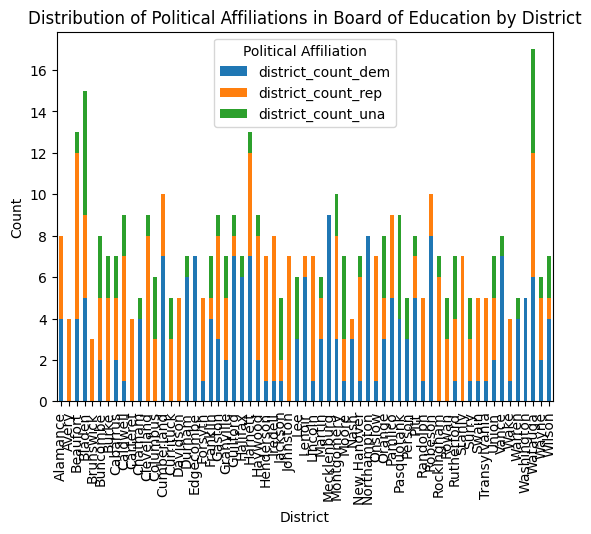

In [174]:
plt.figure(figsize=(10, 6))
board_ed.groupby('countydescription')[['district_count_dem', 'district_count_rep', 'district_count_una']].sum().plot(kind='bar', stacked=True)
plt.title('Distribution of Political Affiliations in Board of Education by District')
plt.xlabel('District')
plt.ylabel('Count')
plt.legend(title='Political Affiliation')
plt.show()

In [171]:
board_ed.groupby('countydescription')[['district_count_dem', 'district_count_rep', 'district_count_una']].sum().describe()

,district_count_dem,district_count_rep,district_count_una
count,63.000000,63.000000,63.000000
mean,2.857143,3.158730,1.238095
std,2.532735,2.308514,1.410951
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,2.000000,3.000000,1.000000
75%,4.500000,5.000000,2.000000
max,9.000000,8.000000,6.000000


In [173]:
merge_charter_district.groupby('countydescription')[['count_dem', 'count_rep', 'count_una']].sum().describe()

,count_dem,count_rep,count_una
count,63.000000,63.000000,63.000000
mean,9.523810,6.857143,9.095238
std,17.111454,9.812528,15.997696
min,0.000000,0.000000,0.000000
25%,2.000000,1.500000,3.000000
50%,4.000000,4.000000,4.000000
75%,8.000000,8.000000,9.000000
max,88.000000,58.000000,106.000000


In [175]:
merge_charter_district.groupby('countydescription')[['count_dem', 'count_rep', 'count_una']].sum() 

,count_dem,count_rep,count_una
countydescription,,,
Alamance,14,9,10
Avery,1,3,3
Beaufort,5,4,7
Bladen,9,2,4
Brunswick,2,9,3
...,...,...,...
Warren,6,2,2
Washington,2,2,3
Watauga,2,0,3


In [179]:
merge_charter_district

,countydescription,political_afil,extract_name_clean_list,schoolname,principal/directoremail,website,board_of_directors_link,link_domain_match,director_first_last,cleaner_names,...,postal_code,latitude,longitude,count_dem,count_rep,count_una,district_count_dem,district_count_rep,district_count_una,Percentage
0,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",North Carolina Cyber Academy,mhill@myncca.com,myncca.com,https://www.myncca.com/our-school-board,True,"[('Jill', 'Hammergren'), ('Audrey', 'Martin'),...","['Julie Marks', 'Jill Hammergren', 'Debora Wil...",...,27713,35.9112,-78.9178,5,2,0,6,0,1,0.436137
1,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",NC Virtual Academy,kgomersall@ncvacademy.org,ncvacademy.org,https://ncva.k12.com/about-our-school/board-of...,False,"[('Sara', 'W'), ('C.', 'Struhs'), ('Sara', 'St...","['Steven Peters', 'Sara Struhs', 'Mark Fleming...",...,27713,35.9112,-78.9178,2,2,2,6,0,1,0.373832
2,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Maureen Joy Charter School,Dcannon@joycharter.org,joycharter.org,https://www.joycharter.org/board,True,"[('Elan', 'Hope'), ('Helen', 'Bryant'), ('Regi...","['Elan Hope', 'Helen Bryant', 'Reginald J. Joh...",...,27703,35.9781,-78.8439,6,1,2,6,0,1,0.560748
3,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Durham Charter School,aquigley@durhamcharter.org,durhamcharter.org,https://www.durhamcharter.org/board-of-directors/,True,"[('Matt', 'Les'), ('Preston', 'Michael'), ('Ca...","['Gerald Mc Nair', 'Elizabeth Gnatek Morey Ch...",...,27701,35.9967,-78.8966,2,4,4,6,0,1,0.623053
4,Durham,"[DEM, UNA, DEM, DEM, DEM, DEM, DEM]","['Bettina Umstead', ' Emily Chavez', ' Natalie...",Community School of Digital & Visual Art,OAdeniyi@communitydva.org,communitydva.org,https://www.communitydva.org/,True,[],"['Brian Crawford', 'Joe Battle', 'Michael Palm...",...,27705,36.0218,-78.9478,5,0,1,6,0,1,0.373832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Watauga,"[UNA, UNA, DEM, DEM, REP, UNA, REP, DEM, DEM, ...","['Gary L. Childers', ' John Fenwick', ' John A...",Two Rivers Community School,natalie@trcsboone.org,trcsboone.org,https://www.trgators.org/o/two-rivers-school-d...,False,"[('Stele', 'James'), ('Doug', 'Morell'), ('Rya...","['Melissa Thomas', 'Carole Greene', 'Twila Win...",...,28607,36.2142,-81.6660,2,0,3,6,6,5,0.311526
202,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Dillard Academy,cbattle@dillardacademy.org,dillardacademy.org,http://www.dillardacademy.org/board-of-directo...,True,"[('Janet', 'Ward'), ('Thomas', 'Smith'), ('Mar...","['Janet Ward', 'Christina Robles', 'Mary James...",...,27530,35.3683,-78.0929,3,3,1,2,3,1,0.436137
203,Wayne,"[REP, REP, DEM, DEM, UNA, REP]","['Wade Leatham', ' Craig Foucht', ' H. Len Hen...",Wayne Preparatory Academy,jtwitty@wpanc.org,wpanc.org,https://wpanc.net/our-board/,False,"[('Amanda', 'Wells'), ('Scott', 'Mack'), ('Cha...","['Charles Gaylor', 'Scott Mackey', 'Amanda Wel...",...,27530,35.3683,-78.0929,1,1,1,2,3,1,0.186916
204,Wilson,"[DEM, DEM, DEM, UNA, DEM, UNA, REP]","['Debora Powell', ' Velma Barnes', ' Christine...",Sallie B Howard School,"jwoodard@sallieb.net, sandeep@sallieb.net",sallieb.net,https://salliebhowardschool.com/meet-our-staff...,False,"[('JoAnne', 'Woodard'), ('JoAnne', 'Woodard')]",['JoAnne Woodard'],...,27893,35.7270,-77.9227,0,1,0,4,1,2,0.062305
